In [20]:
import sympy as sym

# sym.Eq
x, y, m, b = sym.symbols('x y m b')
teh_basic_one = sym.Eq(y, x*m + b)

test1 = teh_basic_one.replace(b, 1)
test1
test2 = test1.replace(m,3)
test2

Eq(y, 3*x + 1)

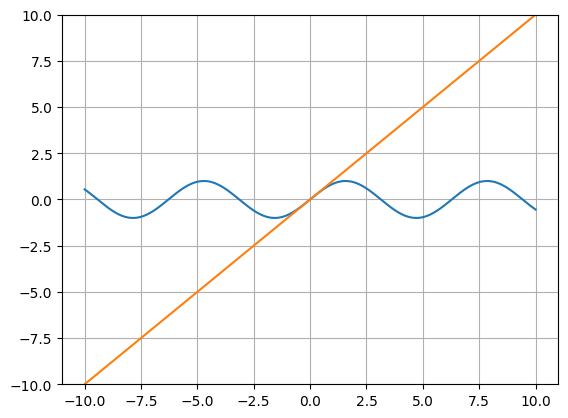

In [50]:
import matplotlib.pyplot as plt
from numpy import linspace, sin

x = linspace(-10, 10, 1000)

#y = 3*x+1
#plt.plot(x, y)

#y = x**2
#plt.plot(x, y)

y = sin(x)
plt.plot(x, y)

y = x
plt.plot(x, y)

plt.ylim(-10, 10)

plt.grid()

# other stuff

In [30]:
import cirq

# Define two qubits
q0 = cirq.LineQubit(0)
q1 = cirq.LineQubit(1)

# Define the |01> state
initial_state = [0, 1, 0, 0]  # |01>

# Define the XX + YY operator using Cirq's PauliString
xx = cirq.PauliString(cirq.X(q0) * cirq.X(q1))
yy = cirq.PauliString(cirq.Y(q0) * cirq.Y(q1))

# Combine XX + YY
operator = xx + yy

# Create a circuit to apply the operator
circuit = cirq.Circuit()

# Prepare the initial state |01> using single-qubit gates
circuit.append(cirq.X(q1))  # Flip q0 to |1> (now |01>)

circuit.append(operator)

## Add the XX + YY operator as a gate
#circuit.append(cirq.PauliSumExponential(operator, exponent=1.0))
#
# Simulate the circuit
simulator = cirq.Simulator()
result = simulator.simulate(circuit, initial_state=initial_state)

# Print the final state vector
print("Final state vector after applying XX + YY:")
print(result.final_state_vector)

Final state vector after applying XX + YY:
[-1.+0.j  0.+0.j  0.+0.j  0.+0.j]


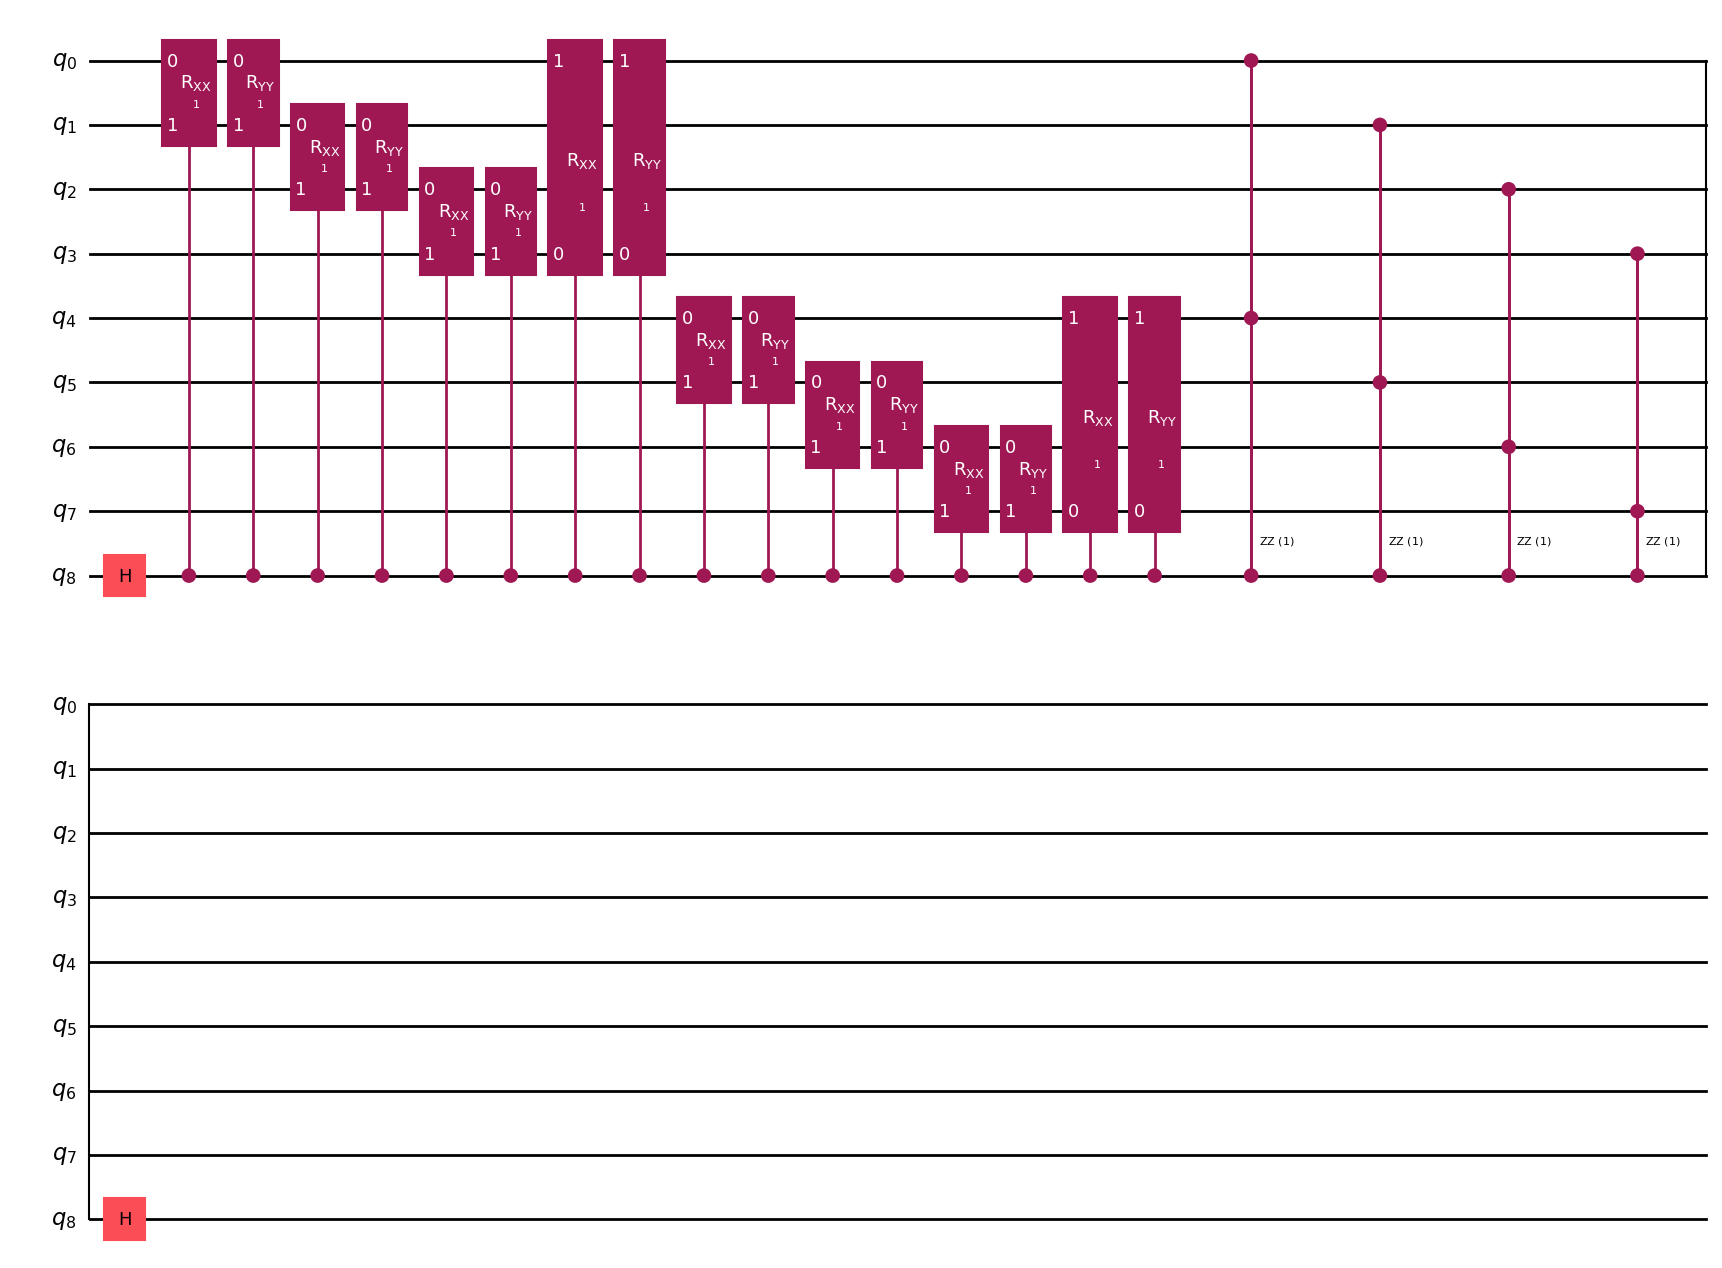

In [6]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import RXXGate, RYYGate, RZZGate

def controlled_XX_YY(qc, ancilla, q1, q2, t):
    """Applies controlled-RXX and controlled-RYY gates."""
    qc.append(RXXGate(2*t).control(1), [ancilla, q1, q2])
    qc.append(RYYGate(2*t).control(1), [ancilla, q1, q2])

def controlled_ZZ(qc, ancilla, q1, q2, t):
    """Applies controlled-RZZ gate."""
    qc.append(RZZGate(2*t).control(1), [ancilla, q1, q2])

N = 4  # Number of qubits per ring
qc = QuantumCircuit(2 * N + 1)  # Extra qubit for the ancilla

ancilla = 2 * N  # The last qubit is the ancilla

# Initialize ancilla in |+> state for potential applications
qc.h(ancilla)

# First ring: controlled XX + YY interactions
for i in range(N):
    controlled_XX_YY(qc, ancilla, i, (i+1) % N, t=0.5)

# Second ring: controlled XX + YY interactions
for i in range(N):
    controlled_XX_YY(qc, ancilla, i + N, (i+1) % N + N, t=0.5)

# Inter-ring controlled ZZ interactions
for i in range(N):
    controlled_ZZ(qc, ancilla, i, i + N, t=0.5)

# Apply Hadamard to ancilla again if using phase estimation
qc.h(ancilla)

qc.draw('mpl')


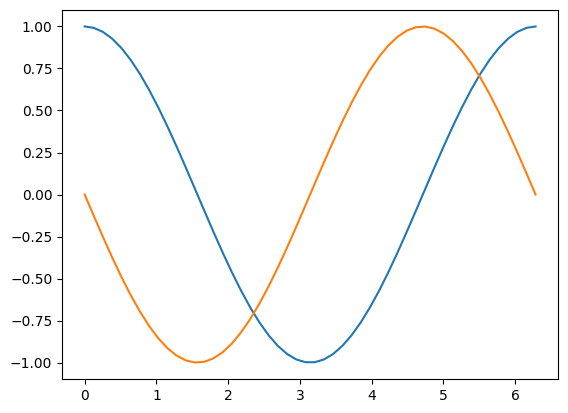

In [12]:
from numpy import exp, linspace, pi
import matplotlib.pyplot as plt
x = linspace(0, 2*pi)
result = exp(-1j*x)

plt.plot(x, result.real)
plt.plot(x, result.imag)